In [1]:
import pandas as pd
from pandas import DataFrame, Series
#false positive warnings all the time:
pd.options.mode.chained_assignment = None

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import statistics

import os.path

In [2]:
#http://matplotlib.org/1.4.0/users/customizing.html

plt.style.use('ggplot')

mpl.rcParams['font.size'] = 18

### LINES
mpl.rcParams['lines.linewidth'] = '2.0'        # line width in points
mpl.rcParams['lines.marker']    = 'None'
mpl.rcParams['lines.markersize']=  '6'          # markersize, in points

###LEGEND
mpl.rcParams['legend.fontsize']='medium'

### GRIDS
mpl.rcParams['grid.color']='black'     # grid color
mpl.rcParams['grid.linestyle'] =':'    # dotted
mpl.rcParams['grid.linewidth']='0.5'   # in points
mpl.rcParams['grid.alpha']='1.0'       # transparency, between 0.0 and 1.0

### TICKS
mpl.rcParams['xtick.labelsize']="small"  # fontsize of the tick labels
mpl.rcParams['xtick.direction']="out"      # direction: in, out, or inout
mpl.rcParams['ytick.labelsize']="small"   # fontsize of the tick labels
mpl.rcParams['ytick.direction']="out"      # direction: in, out, or inout

### AXES
mpl.rcParams['axes.linewidth']  =  '1.0'    # edge linewidth
mpl.rcParams['axes.grid']       =  'True'   # display grid or not
mpl.rcParams['axes.titlesize']  =  'large'  # fontsize of the axes title
mpl.rcParams['axes.labelsize']  = 'large'  # fontsize of the x any y labels
mpl.rcParams['axes.facecolor']= 'white'     # axes background color

mpl.rcParams['figure.facecolor']= '1.0'     # figure facecolor; 0.75 is scalar gray

In [3]:
def generateFilenameResultsPerQuery(bmtuple):
    fname = './resultsperquery_csv/' +  bmtuple[0] + "_N" + str(bmtuple[1]) + "_" + str(bmtuple[2]) + "_" + bmtuple[3] + "_" + bmtuple[4]
    if len(str(bmtuple[5])) != 0:
        fname = fname + "_" + str(bmtuple[5])
    return fname + "_queryresults.csv" 


def generateSimulationID(tup):
    identifier = tup[0] \
            + "_N" + str(tup[1]) \
            + "_" + str(tup[2]) \
            + "_" + tup[3] \
            + "_" + tup[4] \
    
    extra = ""
    if len(tup[5]) !=0:
        extra = "_" + str(tup[5])
    
    return identifier+extra


simulation_map = {
    "Watdiv10M": "W10", "Watdiv100M": "W100", "Watdiv1000M": "W1000", "Ontoforce": "Ont"
}

def generateSimulationIDCompact(tup, pref_length=3):
    #pref_length = 3
    identifier = tup[0][:pref_length] \
            + "_N" + str(tup[1]) \
            + "_" + str(tup[2]) \
            + "_" + simulation_map[tup[3]] \
            + "_" + str(tup[4])[:pref_length] \
    
    extra = ""
    if len(tup[5]) !=0:
        extra = "_" + str(tup[5])
    
    return identifier+extra

# 1. Create a consensus DataFrame: number of results per query

* we start from *query_results.csv since we already observed that between threads the results are always consistent

***REMARK (warmup threads x mixsize + stress threads x mixsize:*** 
    
    - A  (NoSQL,1,32,Watdiv10M,Default)     => #query events = 3 x 2000 + 10 x 2000
    - B  (NoSQL,1,32,Watdiv100M,Default)    => #query events = 3 x 2000 + 10 x 2000
    - C  (NoSQL,1,32,Watdiv1000M,Default)   => #query events = 1 x 2000 + 3 x 2000
    - D1 (NoSQL,1,64,Watdiv1000M,Default)   => #query events = 1 x 400  + 5 x 400 
    - D2 (NoSQL,1,64,Watdiv1000M,Optimized) => #query events = 1 x 400  + 5 x 400 
    - D3 (Other,1,64,Watdiv1000M,Default)   => #query events = 1 x 400  + 5 x 400 
    - E1 (Other,1,64,Watdiv100M,Default)    => #query events = 1 x 400  + 5 x 400 




## A.  (NoSQL,1,32,Watdiv10M,Default)     => #query events = 3 x 2000 + 10 x 2000

### Tryout: Reuse functionality from 09_IntersimQueryCorrectness

In [4]:
bm_tup = ('Blazegraph', 1, 64, 'Watdiv1000M', 'Optimized', '')
filename = generateFilenameResultsPerQuery(bm_tup)
df = pd.read_csv(filename, sep='\t')
df.head(n=5)

,sim_id,query_name,number_of_results
0,Bla_N1_64_W1000_Opt,C1/C1_split0.sparql,1424
1,Bla_N1_64_W1000_Opt,C1/C1_split1.sparql,1424
2,Bla_N1_64_W1000_Opt,C1/C1_split10.sparql,1424
3,Bla_N1_64_W1000_Opt,C1/C1_split11.sparql,1424
4,Bla_N1_64_W1000_Opt,C1/C1_split12.sparql,1424


In [5]:
def getInconsistentResultQueries(tuple_list):
    dfs = [pd.read_csv(generateFilenameResultsPerQuery(bm_tuple),sep='\t') for bm_tuple in tuple_list]
    df_all = pd.concat(dfs)
    grouped =  df_all.groupby(['query_name'], as_index=False)
    df_consistent = grouped.agg({'number_of_results': pd.Series.nunique})
    df_consistent = df_consistent.rename(columns={"number_of_results": "number_of_different_results"})
    df_inconsistent = df_consistent[df_consistent['number_of_different_results'] !=1]
    
    return df_inconsistent

def reworkResultsDF(tuple_list):
    dfs = []
    
    for bm_tuple in tuple_list:
        df = pd.read_csv(generateFilenameResultsPerQuery(bm_tuple),sep='\t')
        df = df.rename(columns={'number_of_results': generateSimulationIDCompact(bm_tuple)})
        df.drop('sim_id', axis=1, inplace=True)    
        dfs.append(df)
    
    df_combined = None
    
    for df in dfs:
        if df_combined is None:
            df_combined = df
        else:
            df_combined = pd.merge(df_combined, df, how='outer', on='query_name')
    return df_combined

In [6]:
tuple_list = [('Blazegraph', 1, 32,'Watdiv10M', 'Default', ''), \
    ('GraphDB', 1, 32,'Watdiv10M', 'Default', ''), \
    ('ES', 1, 32,'Watdiv10M', 'Default', ''), \
    ('Virtuoso', 1, 32,'Watdiv10M', 'Default', '')]  

In [7]:
df_inc = getInconsistentResultQueries(tuple_list)
df_inc.head(n=5)

,query_name,number_of_different_results
200,C3/C3_split0.sparql,2
201,C3/C3_split1.sparql,2
202,C3/C3_split10.sparql,2
203,C3/C3_split11.sparql,2
204,C3/C3_split12.sparql,2


In [8]:
df_combined = reworkResultsDF(tuple_list)
df_inconsistent = pd.merge(df_inc, df_combined, how='inner', on='query_name')
df_inconsistent.head(n=5)

,query_name,number_of_different_results,Bla_N1_32_W10_Def,Gra_N1_32_W10_Def,ES_N1_32_W10_Def,Vir_N1_32_W10_Def
0,C3/C3_split0.sparql,2,434169,434169,434169,100000
1,C3/C3_split1.sparql,2,434169,434169,434169,100000
2,C3/C3_split10.sparql,2,434169,434169,434169,100000
3,C3/C3_split11.sparql,2,434169,434169,434169,100000
4,C3/C3_split12.sparql,2,434169,434169,434169,100000


### 100 C3 queries of Vir_N1_32_W10_Def are incorrect due to config parameter limiting the number of results

In [9]:
df_inconsistent.shape

(100, 6)

### Creating consensus corresponds to taking the max results per row

In [10]:
def getConsensusResultsPerQuery(tuple_list):
    dfs = [pd.read_csv(generateFilenameResultsPerQuery(bm_tuple),sep='\t') for bm_tuple in tuple_list]
    df_all = pd.concat(dfs)
    grouped =  df_all.groupby(['query_name'], as_index=False)
    df_consistent = grouped.agg({'number_of_results': pd.Series.max})
    df_consensus = df_consistent.rename(columns={"number_of_results": "consensus"})
    return df_consensus

In [11]:
df_inc = getInconsistentResultQueries(tuple_list)
df_inc.head(n=5)

,query_name,number_of_different_results
200,C3/C3_split0.sparql,2
201,C3/C3_split1.sparql,2
202,C3/C3_split10.sparql,2
203,C3/C3_split11.sparql,2
204,C3/C3_split12.sparql,2


In [12]:
df_inc.shape

(100, 2)

In [13]:
df_consensus = getConsensusResultsPerQuery(tuple_list)
mask = df_consensus['query_name'].str.contains('C3')
df_consensus[mask].head(n=5)

,query_name,consensus
200,C3/C3_split0.sparql,434169
201,C3/C3_split1.sparql,434169
202,C3/C3_split10.sparql,434169
203,C3/C3_split11.sparql,434169
204,C3/C3_split12.sparql,434169


In [14]:
df_consensus.to_csv('./inconsistent_queryresults/NoSQL_queryconsensus_Watdiv10M.csv', sep='\t', index=False)


## B  (NoSQL,1,32,Watdiv100M,Default)    => #query events = 3 x 2000 + 10 x 2000


* Note: log files for ES not available


In [15]:
tuple_list = [('Blazegraph', 1, 32,'Watdiv100M', 'Default', ''), \
    ('GraphDB', 1, 32,'Watdiv100M', 'Default', ''), \
    #('ES', 1, 32,'Watdiv100M', 'Default', ''), \
    ('Virtuoso', 1, 32,'Watdiv100M', 'Default', '')]  


df_inc = getInconsistentResultQueries(tuple_list)
df_combined = reworkResultsDF(tuple_list)
df_inconsistent = pd.merge(df_inc, df_combined, how='inner', on='query_name')
df_inconsistent.head(n=5)

,query_name,number_of_different_results,Bla_N1_32_W100_Def,Gra_N1_32_W100_Def,Vir_N1_32_W100_Def
0,C3/C3_split0.sparql,2,4244261,4244261,100000
1,C3/C3_split1.sparql,2,4244261,4244261,100000
2,C3/C3_split10.sparql,2,4244261,4244261,100000
3,C3/C3_split11.sparql,2,4244261,4244261,100000
4,C3/C3_split12.sparql,2,4244261,4244261,100000


### 100 C3 queries of Vir_N1_32_W100_Def are incorrect due to config parameter limiting the number of results

In [16]:
df_inconsistent.shape

(100, 5)

In [17]:
df_consensus = getConsensusResultsPerQuery(tuple_list)
mask = df_consensus['query_name'].str.contains('C3')
df_consensus[mask].head(n=5)

,query_name,consensus
200,C3/C3_split0.sparql,4244261
201,C3/C3_split1.sparql,4244261
202,C3/C3_split10.sparql,4244261
203,C3/C3_split11.sparql,4244261
204,C3/C3_split12.sparql,4244261


In [18]:
df_consensus.to_csv('./inconsistent_queryresults/NoSQL_queryconsensus_Watdiv100M.csv', sep='\t', index=False)


## C.  (NoSQL,1,32,Watdiv1000M,Default)   => #query events = 1 x 2000 + 3 x 2000

* Virtuoso Default => number of results limited to 1e5
* NOTE: no logs vor GraphDB N1 Default 32GB

In [19]:
tuple_list = [ \
                ('Blazegraph', 1, 32,'Watdiv1000M', 'Default', '')  , \
                #('GraphDB', 1, 32,'Watdiv1000M', 'Default', '')    , \
                ('ES', 1, 32,'Watdiv1000M', 'Default', '')          ,  \
                ('Virtuoso', 1, 32,'Watdiv1000M', 'Default', '')       \
          
             ]         
             
df_inc = getInconsistentResultQueries(tuple_list)
df_combined = reworkResultsDF(tuple_list)
df_inconsistent = pd.merge(df_inc, df_combined, how='inner', on='query_name')
df_inconsistent.head(n=100)

,query_name,number_of_different_results,Bla_N1_32_W1000_Def,ES_N1_32_W1000_Def,Vir_N1_32_W1000_Def
0,C3/C3_split10.sparql,2,42063279.0,NaN,100000
1,C3/C3_split12.sparql,2,42063279.0,NaN,100000
2,C3/C3_split13.sparql,2,42063279.0,NaN,100000
3,C3/C3_split19.sparql,2,42063279.0,NaN,100000
4,C3/C3_split22.sparql,2,42063279.0,NaN,100000
5,C3/C3_split25.sparql,2,42063279.0,NaN,100000
6,C3/C3_split27.sparql,2,42063279.0,NaN,100000
7,C3/C3_split28.sparql,2,42063279.0,NaN,100000
8,C3/C3_split36.sparql,2,42063279.0,NaN,100000
9,C3/C3_split39.sparql,2,42063279.0,NaN,100000


In [20]:
df_combined
mask = df_combined['query_name'].str.contains('C3')
df_combined[mask]

,query_name,Bla_N1_32_W1000_Def,ES_N1_32_W1000_Def,Vir_N1_32_W1000_Def
200,C3/C3_split10.sparql,42063279.0,NaN,100000
201,C3/C3_split12.sparql,42063279.0,NaN,100000
202,C3/C3_split13.sparql,42063279.0,NaN,100000
203,C3/C3_split19.sparql,42063279.0,NaN,100000
204,C3/C3_split22.sparql,42063279.0,NaN,100000
205,C3/C3_split25.sparql,42063279.0,NaN,100000
206,C3/C3_split27.sparql,42063279.0,NaN,100000
207,C3/C3_split28.sparql,42063279.0,NaN,100000
208,C3/C3_split36.sparql,42063279.0,NaN,100000
209,C3/C3_split39.sparql,42063279.0,NaN,100000


### 20/100 C3 queries of Vir_N1_32_W1000_Def are incorrect due to config parameter limiting the number of results 
### 80/100 C3 queries only Virtuoso reported 1e5 results and Blazegraph had timeouts, it's reasonable to assume that Virtuoso is also incorrect there!

 

In [21]:
df_inconsistent.shape

(20, 5)

In [22]:
df_consensus = getConsensusResultsPerQuery(tuple_list)
mask = df_consensus['query_name'].str.contains('C3')
#overwrite 1e5 values of Virtuoso since they are most likely incorrect
df_consensus.loc[mask, 'consensus'] = 42063279
df_consensus[mask].head(n=10)

,query_name,consensus
200,C3/C3_split0.sparql,42063279
201,C3/C3_split1.sparql,42063279
202,C3/C3_split10.sparql,42063279
203,C3/C3_split11.sparql,42063279
204,C3/C3_split12.sparql,42063279
205,C3/C3_split13.sparql,42063279
206,C3/C3_split14.sparql,42063279
207,C3/C3_split15.sparql,42063279
208,C3/C3_split16.sparql,42063279
209,C3/C3_split17.sparql,42063279


In [23]:
df_consensus.to_csv('./inconsistent_queryresults/NoSQL_queryconsensus_Watdiv1000M.csv', sep='\t', index=False)


## D1 (NoSQL,1,64,Watdiv1000M,Default)   => #query events = 1 x 400  + 5 x 400 
## D2 (NoSQL,1,64,Watdiv1000M,Optimized) => #query events = 1 x 400  + 5 x 400 
## D3 (Other,1,64,Watdiv1000M,Default)   => #query events = 1 x 400  + 5 x 400 

* Virtuoso optimized => hardcode upper boundary for number of results: 2^20


In [24]:
tuple_list = [ \
                ('Blazegraph', 1, 64,'Watdiv1000M', 'Default', '')  , \
                ('GraphDB', 1, 64,'Watdiv1000M', 'Default', '')     , \
                ('ES', 1, 64,'Watdiv1000M', 'Default', '')          , \
                ('Virtuoso', 1, 64,'Watdiv1000M', 'Default', '')    , \
                ('Blazegraph', 1, 64,'Watdiv1000M', 'Optimized', ''), \
                ('GraphDB', 1, 64,'Watdiv1000M', 'Optimized', '')   , \
                #('ES', 1, 64,'Watdiv1000M', 'Optimized', '')       , \
                ('Virtuoso', 1, 64,'Watdiv1000M', 'Optimized', '')  , \
                ('Fuseki', 1, 64,'Watdiv1000M', 'Default', '')      , \
                ('FluidOps', 3, 64,'Watdiv1000M', 'Default', '')    , \
                ('LDF', 1, 64,'Watdiv1000M', 'Default', '')         , \
                ('LDF', 3, 64,'Watdiv1000M', 'Default', '')           \
             ]  
df_inc = getInconsistentResultQueries(tuple_list)
df_combined = reworkResultsDF(tuple_list)
df_inconsistent = pd.merge(df_inc, df_combined, how='inner', on='query_name')
df_inconsistent.head(n=10)

,query_name,number_of_different_results,Bla_N1_64_W1000_Def,Gra_N1_64_W1000_Def,ES_N1_64_W1000_Def,Vir_N1_64_W1000_Def,Bla_N1_64_W1000_Opt,Gra_N1_64_W1000_Opt,Vir_N1_64_W1000_Opt,Fus_N1_64_W1000_Def,Flu_N3_64_W1000_Def,LDF_N1_64_W1000_Def,LDF_N3_64_W1000_Def
0,C3/C3_split0.sparql,2,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
1,C3/C3_split1.sparql,2,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
2,C3/C3_split10.sparql,2,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
3,C3/C3_split11.sparql,2,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
4,C3/C3_split12.sparql,2,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
5,C3/C3_split13.sparql,2,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
6,C3/C3_split14.sparql,2,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
7,C3/C3_split15.sparql,2,42063279.0,NaN,NaN,1048576,42063279,42063279.0,1048576,NaN,NaN,NaN,NaN
8,C3/C3_split16.sparql,2,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
9,C3/C3_split17.sparql,2,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN


### Given more resources, Blazegraph can solve all C3 queries correctly => good reference!

In [25]:
df_combined
mask = df_combined['query_name'].str.contains('C3')
df_combined[mask]

,query_name,Bla_N1_64_W1000_Def,Gra_N1_64_W1000_Def,ES_N1_64_W1000_Def,Vir_N1_64_W1000_Def,Bla_N1_64_W1000_Opt,Gra_N1_64_W1000_Opt,Vir_N1_64_W1000_Opt,Fus_N1_64_W1000_Def,Flu_N3_64_W1000_Def,LDF_N1_64_W1000_Def,LDF_N3_64_W1000_Def
40,C3/C3_split0.sparql,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
41,C3/C3_split1.sparql,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
42,C3/C3_split10.sparql,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
43,C3/C3_split11.sparql,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
44,C3/C3_split12.sparql,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
45,C3/C3_split13.sparql,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
46,C3/C3_split14.sparql,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
47,C3/C3_split15.sparql,42063279.0,NaN,NaN,1048576,42063279,42063279.0,1048576,NaN,NaN,NaN,NaN
48,C3/C3_split16.sparql,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN
49,C3/C3_split17.sparql,42063279.0,NaN,NaN,1048576,42063279,NaN,1048576,NaN,NaN,NaN,NaN


### 20 C3 queries incorrectly solved by Virtuoso

In [26]:
df_inconsistent.shape

(20, 13)

In [27]:
df_consensus = getConsensusResultsPerQuery(tuple_list)
mask = df_consensus['query_name'].str.contains('C3')
df_consensus[mask].head(n=5)

,query_name,consensus
40,C3/C3_split0.sparql,42063279
41,C3/C3_split1.sparql,42063279
42,C3/C3_split10.sparql,42063279
43,C3/C3_split11.sparql,42063279
44,C3/C3_split12.sparql,42063279


In [28]:
df_consensus.to_csv('./inconsistent_queryresults/All_queryconsensus_Watdiv1000M_64.csv', sep='\t', index=False)


## E (Other,1,64,Watdiv100M,Default)    => #query events = 1 x 400  + 5 x 400 

* approach of taking max results has issues

In [29]:
tuple_list = [('Fuseki', 1, 64,'Watdiv100M', 'Default', ''), \
    ('FluidOps', 3, 64,'Watdiv100M', 'Default', ''), \
    ('LDF', 1, 64,'Watdiv100M', 'Default', ''), \
    ('LDF', 3, 64,'Watdiv100M', 'Default', '')]  

df_inc = getInconsistentResultQueries(tuple_list)
df_combined = reworkResultsDF(tuple_list)
df_inconsistent = pd.merge(df_inc, df_combined, how='inner', on='query_name')
df_inconsistent.head(n=100)

,query_name,number_of_different_results,Fus_N1_64_W100_Def,Flu_N3_64_W100_Def,LDF_N1_64_W100_Def,LDF_N3_64_W100_Def
0,C1/C1_split18.sparql,2,201.0,199.0,201.0,NaN


In [30]:
df_combined

,query_name,Fus_N1_64_W100_Def,Flu_N3_64_W100_Def,LDF_N1_64_W100_Def,LDF_N3_64_W100_Def
0,C1/C1_split0.sparql,201.0,NaN,201.0,NaN
1,C1/C1_split1.sparql,201.0,NaN,201.0,NaN
2,C1/C1_split10.sparql,201.0,NaN,201.0,NaN
3,C1/C1_split11.sparql,201.0,NaN,201.0,NaN
4,C1/C1_split12.sparql,201.0,NaN,201.0,NaN
5,C1/C1_split13.sparql,201.0,NaN,201.0,NaN
6,C1/C1_split14.sparql,201.0,NaN,201.0,NaN
7,C1/C1_split15.sparql,201.0,NaN,201.0,NaN
8,C1/C1_split16.sparql,201.0,NaN,201.0,NaN
9,C1/C1_split17.sparql,201.0,NaN,201.0,NaN


### Only 1 inconsistent query, where we assume LDF is correct since C1 queries have 201 results in other Watdiv100 benchmarks

* Note that there are 35 queries with no results for any of the engines!

In [31]:
df_inconsistent.shape

(1, 6)

In [32]:
df_combined.shape

(365, 5)

In [33]:
df_consensus = getConsensusResultsPerQuery(tuple_list)
#mask = df_consensus['query_name'].str.contains('C3')
df_consensus.head(n=5)

,query_name,consensus
0,C1/C1_split0.sparql,201
1,C1/C1_split1.sparql,201
2,C1/C1_split10.sparql,201
3,C1/C1_split11.sparql,201
4,C1/C1_split12.sparql,201


In [34]:
df_consensus.to_csv('./inconsistent_queryresults/Other_queryconsensus_Watdiv100M_64.csv', sep='\t', index=False)


# 2. Create a Sim_queryevents_correct.csv 

* additional column with a status on whether the query was correct: CORRECT, INCORRECT, INCERTAIN

### Tryout

In [35]:
def generateFilenameQueryEvents(bmtuple):
    fname = './csv/' +  bmtuple[0] + "_N" + str(bmtuple[1]) + "_" + str(bmtuple[2]) + "_" + bmtuple[3] + "_" + bmtuple[4]
    if len(str(bmtuple[5])) != 0:
        fname = fname + "_" + str(bmtuple[5])
    return fname + "_queryevents.csv"

def generateFilenameQueryEventsCorrect(bmtuple):
    fname = './csv_correct/' +  bmtuple[0] + "_N" + str(bmtuple[1]) + "_" + str(bmtuple[2]) + "_" + bmtuple[3] + "_" + bmtuple[4]
    if len(str(bmtuple[5])) != 0:
        fname = fname + "_" + str(bmtuple[5])
    return fname + "_queryevents_correct.csv"


In [36]:
bm_tup = ('Blazegraph', 1, 64, 'Watdiv1000M', 'Optimized', '')
filename = generateFilenameQueryEvents(bm_tup)
df = pd.read_csv(filename, sep='\t')
df.head(n=5)

,sim_id,query_name,thread_id,thread_type,order_id,number_of_results,runtime,flag
0,Bla_N1_64_W1000_Opt,F1/F1_split15.sparql,1,warmup,1,3,36.716864,SUCCESS
1,Bla_N1_64_W1000_Opt,F5/F5_split2.sparql,1,warmup,2,45,2.921069,SUCCESS
2,Bla_N1_64_W1000_Opt,F3/F3_split11.sparql,1,warmup,3,3506,73.508722,SUCCESS
3,Bla_N1_64_W1000_Opt,F2/F2_split7.sparql,1,warmup,4,1141,42.756679,SUCCESS
4,Bla_N1_64_W1000_Opt,S1/S1_split11.sparql,1,warmup,5,4,1.191238,SUCCESS


In [37]:
filename_queryconsensus = './inconsistent_queryresults/All_queryconsensus_Watdiv1000M_64.csv'
df_consensus = pd.read_csv(filename_queryconsensus, sep='\t')
df_consensus.head(n=5)

,query_name,consensus
0,C1/C1_split0.sparql,1424
1,C1/C1_split1.sparql,1424
2,C1/C1_split10.sparql,1424
3,C1/C1_split11.sparql,1424
4,C1/C1_split12.sparql,1424


In [38]:
df_correct = pd.merge(df, df_consensus, how='outer', on='query_name')

In [39]:
df_correct.head(n=3)

,sim_id,query_name,thread_id,thread_type,order_id,number_of_results,runtime,flag,consensus
0,Bla_N1_64_W1000_Opt,F1/F1_split15.sparql,1,warmup,1,3,36.716864,SUCCESS,3
1,Bla_N1_64_W1000_Opt,F1/F1_split15.sparql,38,stress,147,3,0.509863,SUCCESS,3
2,Bla_N1_64_W1000_Opt,F1/F1_split15.sparql,37,stress,212,3,0.675793,SUCCESS,3


In [40]:
df_correct['correct_temp']= df_correct['number_of_results'] == df_correct['consensus']

In [41]:
mask = df_correct['correct_temp'] == False
df_correct[mask].head(n=5)

,sim_id,query_name,thread_id,thread_type,order_id,number_of_results,runtime,flag,consensus,correct_temp
42,Bla_N1_64_W1000_Opt,C3/C3_split16.sparql,1,warmup,8,-1,300.0,TIMEOUT,42063279,False
144,Bla_N1_64_W1000_Opt,L2/L2_split6.sparql,1,warmup,25,-1,300.0,TIMEOUT,16363,False
210,Bla_N1_64_W1000_Opt,C3/C3_split9.sparql,1,warmup,36,-1,300.0,TIMEOUT,42063279,False
240,Bla_N1_64_W1000_Opt,C2/C2_split12.sparql,1,warmup,41,-1,300.0,TIMEOUT,342,False
246,Bla_N1_64_W1000_Opt,C3/C3_split4.sparql,1,warmup,42,-1,300.0,TIMEOUT,42063279,False


In [42]:
df_correct['correct'] = df_correct['correct_temp'].apply(lambda r: 'CORRECT' if r is True else 'INCORRECT')

In [43]:
df_correct.drop(['consensus', 'correct_temp'], axis=1, inplace=True)

In [44]:
df_correct['correct'].value_counts()

CORRECT      2392
INCORRECT       8
Name: correct, dtype: int64

In [45]:
mask = df_correct['correct'] == 'INCORRECT'
print('incorrect due to timeout')
df_correct[mask]

incorrect due to timeout


,sim_id,query_name,thread_id,thread_type,order_id,number_of_results,runtime,flag,correct
42,Bla_N1_64_W1000_Opt,C3/C3_split16.sparql,1,warmup,8,-1,300.0,TIMEOUT,INCORRECT
144,Bla_N1_64_W1000_Opt,L2/L2_split6.sparql,1,warmup,25,-1,300.0,TIMEOUT,INCORRECT
210,Bla_N1_64_W1000_Opt,C3/C3_split9.sparql,1,warmup,36,-1,300.0,TIMEOUT,INCORRECT
240,Bla_N1_64_W1000_Opt,C2/C2_split12.sparql,1,warmup,41,-1,300.0,TIMEOUT,INCORRECT
246,Bla_N1_64_W1000_Opt,C3/C3_split4.sparql,1,warmup,42,-1,300.0,TIMEOUT,INCORRECT
282,Bla_N1_64_W1000_Opt,C3/C3_split8.sparql,1,warmup,48,-1,300.0,TIMEOUT,INCORRECT
360,Bla_N1_64_W1000_Opt,C3/C3_split11.sparql,1,warmup,61,-1,300.0,TIMEOUT,INCORRECT
372,Bla_N1_64_W1000_Opt,C3/C3_split17.sparql,1,warmup,63,-1,300.0,TIMEOUT,INCORRECT


In [46]:
def assess_correctness(bmtuple, consensus):
    filename = generateFilenameQueryEvents(bmtuple)
    df = pd.read_csv(filename, sep='\t')
    df_consensus = pd.read_csv(consensus, sep='\t')
    df_correct = pd.merge(df, df_consensus, how='outer', on='query_name')
    df_correct['correct_temp']= df_correct['number_of_results'] == df_correct['consensus']
    df_correct['correct'] = df_correct['correct_temp'].apply(lambda r: 'CORRECT' if r is True else 'INCORRECT')
    df_correct.drop(['consensus', 'correct_temp'], axis=1, inplace=True)
    #print(df_correct['correct'].value_counts())
    
    print(pd.crosstab(df_correct['correct'],df_correct['flag']))
    
    full_path = generateFilenameQueryEventsCorrect(bmtuple)
    df_correct.to_csv(full_path, sep='\t', index=False)
    print("Written to: " + str(full_path))
    return
    

In [47]:
assess_correctness(bm_tup, filename_queryconsensus)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT       2392        0
INCORRECT        0        8
Written to: ./csv_correct/Blazegraph_N1_64_Watdiv1000M_Optimized_queryevents_correct.csv


In [48]:
consensus_watdiv100064 = './inconsistent_queryresults/All_queryconsensus_Watdiv1000M_64.csv'
consensus_watdiv10 ='./inconsistent_queryresults/NoSQL_queryconsensus_Watdiv10M.csv'
consensus_watdiv100 ='./inconsistent_queryresults/NoSQL_queryconsensus_Watdiv100M.csv'
consensus_watdiv100032 ='./inconsistent_queryresults/NoSQL_queryconsensus_Watdiv1000M.csv'
consensus_watdiv10064 ='./inconsistent_queryresults/Other_queryconsensus_Watdiv100M_64.csv'

### A Blazegraph Watdiv

* INCORRECT queries are all timeouts

In [49]:
assess_correctness(("Blazegraph", 1, 32, "Watdiv10M", "Default", ""), consensus_watdiv10)

flag     SUCCESS
correct         
CORRECT    26000
Written to: ./csv_correct/Blazegraph_N1_32_Watdiv10M_Default_queryevents_correct.csv


In [50]:
assess_correctness(("Blazegraph", 1, 32, "Watdiv100M", "Default", ""), consensus_watdiv100)

flag     SUCCESS
correct         
CORRECT    26000
Written to: ./csv_correct/Blazegraph_N1_32_Watdiv100M_Default_queryevents_correct.csv


In [51]:
assess_correctness(("Blazegraph", 1, 32, "Watdiv1000M", "Default", ""), consensus_watdiv100032)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT       7216        0
INCORRECT        0      787
Written to: ./csv_correct/Blazegraph_N1_32_Watdiv1000M_Default_queryevents_correct.csv


In [52]:
assess_correctness(("Blazegraph", 1, 64, "Watdiv1000M", "Default", ""), consensus_watdiv100064)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT       2299        0
INCORRECT        0      101
Written to: ./csv_correct/Blazegraph_N1_64_Watdiv1000M_Default_queryevents_correct.csv


In [53]:
assess_correctness(("Blazegraph", 1, 64, "Watdiv1000M", "Optimized", ""), consensus_watdiv100064)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT       2392        0
INCORRECT        0        8
Written to: ./csv_correct/Blazegraph_N1_64_Watdiv1000M_Optimized_queryevents_correct.csv


### B GraphDB Watdiv

* INCORRECT queries are all timeouts

In [54]:
assess_correctness(("GraphDB", 1, 32, "Watdiv10M", "Default", ""), consensus_watdiv10)

flag     SUCCESS
correct         
CORRECT    26000
Written to: ./csv_correct/GraphDB_N1_32_Watdiv10M_Default_queryevents_correct.csv


In [55]:
assess_correctness(("GraphDB", 1, 32, "Watdiv100M", "Default", ""), consensus_watdiv100)

flag     SUCCESS
correct         
CORRECT    26000
Written to: ./csv_correct/GraphDB_N1_32_Watdiv100M_Default_queryevents_correct.csv


In [56]:
print("Log file missing for " + generateFilenameQueryEvents(("GraphDB", 1, 32, "Watdiv1000M", "Default", "")))
#assess_correctness(("GraphDB", 1, 32, "Watdiv1000M", "Default", ""), consensus_watdiv100032)

Log file missing for ./csv/GraphDB_N1_32_Watdiv1000M_Default_queryevents.csv


In [57]:
assess_correctness(("GraphDB", 1, 64, "Watdiv1000M", "Default", ""), consensus_watdiv100064)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT       1972        0
INCORRECT        0      428
Written to: ./csv_correct/GraphDB_N1_64_Watdiv1000M_Default_queryevents_correct.csv


In [58]:
assess_correctness(("GraphDB", 1, 64, "Watdiv1000M", "Optimized", ""), consensus_watdiv100064)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT       2282        0
INCORRECT        0      118
Written to: ./csv_correct/GraphDB_N1_64_Watdiv1000M_Optimized_queryevents_correct.csv


### C ES Watdiv

* INCORRECT queries never flagged successful. Errors are timeouts or runtime error.

In [59]:
assess_correctness(("ES", 1, 32, "Watdiv10M", "Default", ""), consensus_watdiv10)

flag     SUCCESS
correct         
CORRECT    26000
Written to: ./csv_correct/ES_N1_32_Watdiv10M_Default_queryevents_correct.csv


In [60]:
print("Log file missing for " + generateFilenameQueryEvents(("ES", 1, 32, "Watdiv100M", "Default", "")))

#assess_correctness(("ES", 1, 32, "Watdiv100M", "Default", ""), consensus_watdiv100)

Log file missing for ./csv/ES_N1_32_Watdiv100M_Default_queryevents.csv


In [61]:
assess_correctness(("ES", 1, 32, "Watdiv1000M", "Default", ""), consensus_watdiv100032)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0     4249        0
INCORRECT      2        0     1585
Written to: ./csv_correct/ES_N1_32_Watdiv1000M_Default_queryevents_correct.csv


In [62]:
assess_correctness(("ES", 3, 32, "Watdiv1000M", "Default", ""), consensus_watdiv100032)

flag       ERROR  SUCCESS
correct                  
CORRECT        0     3553
INCORRECT   5135        0
Written to: ./csv_correct/ES_N3_32_Watdiv1000M_Default_queryevents_correct.csv


In [63]:
assess_correctness(("ES", 1, 64, "Watdiv1000M", "Default", ""), consensus_watdiv100064)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT       1804        0
INCORRECT        0      596
Written to: ./csv_correct/ES_N1_64_Watdiv1000M_Default_queryevents_correct.csv


### D Virtuoso Watdiv

* INCORRECT queries for C3 query, but for **Virtuoso N3 some additional errors** seem to be present!!!
    
    - 53 additional errors occur in the following queries:
        * F1: 1
        * F3: 46
        * F5: 3
        * S3: 3
        
    - Remarkable is, as can be seen in the figure below, 
        * that this time there is inconsistency between threads 
        * the engine resolves **each query correct at least once** 
        * usually the number of results is **slightly below the actual number of results**.    

In [64]:
assess_correctness(("Virtuoso", 1, 32, "Watdiv10M", "Default", "")       , consensus_watdiv10)

flag       SUCCESS
correct           
CORRECT      24700
INCORRECT     1300
Written to: ./csv_correct/Virtuoso_N1_32_Watdiv10M_Default_queryevents_correct.csv


In [65]:
assess_correctness(("Virtuoso", 1, 32, "Watdiv100M", "Default", "")      , consensus_watdiv100)

flag       ERROR  SUCCESS
correct                  
CORRECT        0    24699
INCORRECT      1     1300
Written to: ./csv_correct/Virtuoso_N1_32_Watdiv100M_Default_queryevents_correct.csv


In [66]:
assess_correctness(("Virtuoso", 1, 32, "Watdiv1000M", "Default", "")     , consensus_watdiv100032)

flag       ERROR  SUCCESS
correct                  
CORRECT        0    11396
INCORRECT      4      600
Written to: ./csv_correct/Virtuoso_N1_32_Watdiv1000M_Default_queryevents_correct.csv


In [67]:
assess_correctness(("Virtuoso", 1, 32, "Watdiv1000M", "Default", "RERUN"), consensus_watdiv100032)

flag       ERROR  SUCCESS
correct                  
CORRECT        0    11398
INCORRECT      2      600
Written to: ./csv_correct/Virtuoso_N1_32_Watdiv1000M_Default_RERUN_queryevents_correct.csv


In [68]:
assess_correctness(("Virtuoso", 3, 32, "Watdiv1000M", "Default", "")     , consensus_watdiv100032)

flag       SUCCESS
correct           
CORRECT      11347
INCORRECT      653
Written to: ./csv_correct/Virtuoso_N3_32_Watdiv1000M_Default_queryevents_correct.csv


In [69]:
assess_correctness(("Virtuoso", 1, 64, "Watdiv1000M", "Default", "")     , consensus_watdiv100064)

flag       SUCCESS
correct           
CORRECT       2280
INCORRECT      120
Written to: ./csv_correct/Virtuoso_N1_64_Watdiv1000M_Default_queryevents_correct.csv


In [70]:
assess_correctness(("Virtuoso", 1, 64, "Watdiv1000M", "Optimized", "")   , consensus_watdiv100064) 

flag       SUCCESS
correct           
CORRECT       2280
INCORRECT      120
Written to: ./csv_correct/Virtuoso_N1_64_Watdiv1000M_Optimized_queryevents_correct.csv


In [71]:
df_v3 = pd.read_csv('./csv_correct/Virtuoso_N3_32_Watdiv1000M_Default_queryevents_correct.csv', sep='\t')
mask1 = df_v3['flag'] == 'SUCCESS' 
mask2 = df_v3['correct'] == 'INCORRECT'
mask3 = df_v3['number_of_results'] != 1048576
df_v3[mask1 & mask2 & mask3].sort_values('query_name').head(n=5)

,sim_id,query_name,thread_id,thread_type,order_id,number_of_results,runtime,flag,correct
880,Vir_N3_32_W1000_Def,F1/F1_split17.sparql,21,stress,933,123,48.990774,SUCCESS,INCORRECT
9429,Vir_N3_32_W1000_Def,F3/F3_split11.sparql,19,stress,980,1234,6.830335,SUCCESS,INCORRECT
7225,Vir_N3_32_W1000_Def,F3/F3_split12.sparql,17,stress,1619,2155,9.362602,SUCCESS,INCORRECT
7227,Vir_N3_32_W1000_Def,F3/F3_split12.sparql,19,stress,1592,2153,9.622435,SUCCESS,INCORRECT
3885,Vir_N3_32_W1000_Def,F3/F3_split21.sparql,19,stress,511,2801,11.218417,SUCCESS,INCORRECT


In [72]:
df_v3[mask1 & mask2 & mask3].sort_values('query_name').to_csv('./csv_correct/Virtuoso_N3_32_Watdiv1000M_ADDITIONALERRORS.csv', index=False, sep='\t')

In [73]:
df_v3_analysis = df_v3[mask1 & mask2 & mask3].sort_values('query_name')

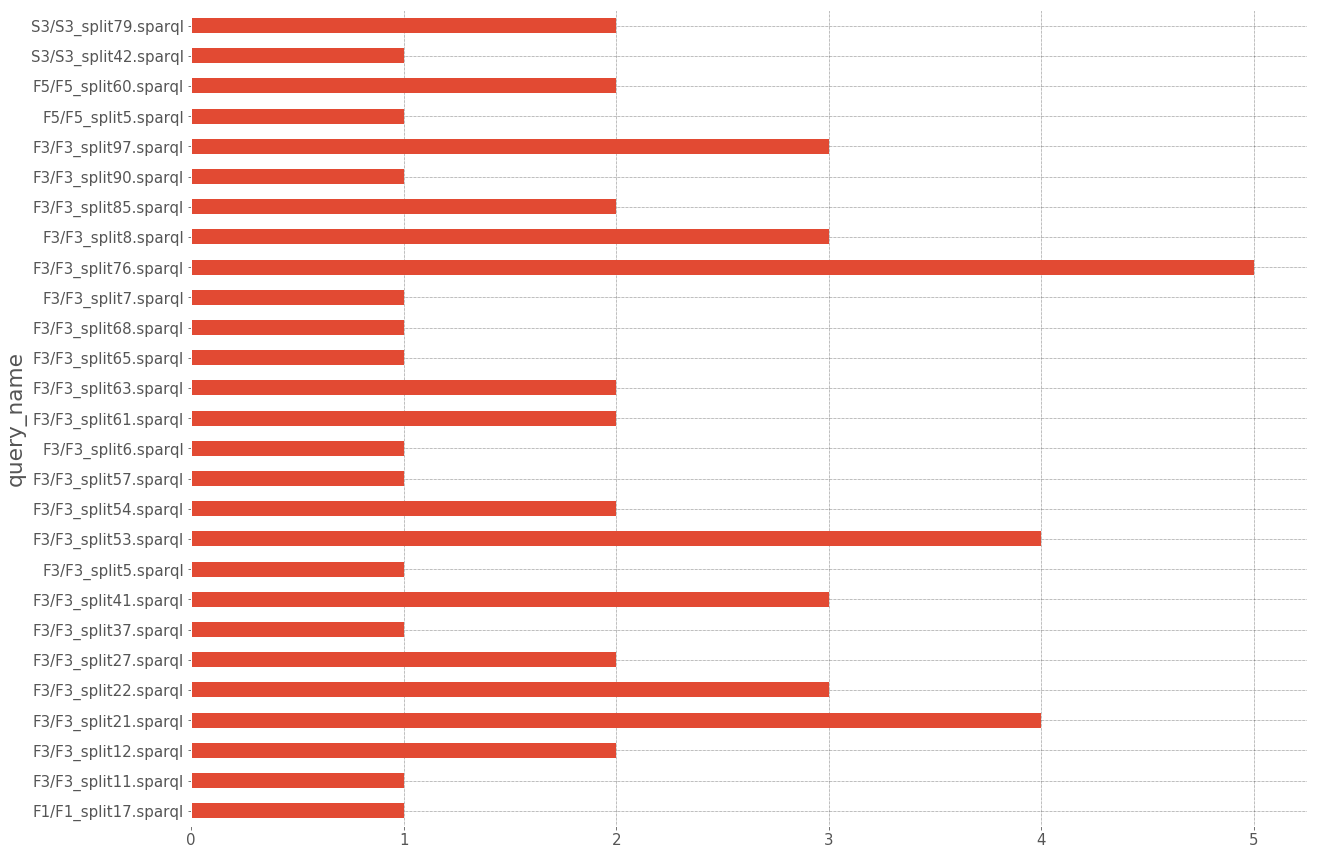

In [74]:
df_v3_analysis.groupby('query_name').size().plot(kind='barh', figsize=(20,15))

### E Fuseki Watdiv

* INCORRECT queries => **a lot of bad queries for fuseki** => results probably unusable?

In [75]:
assess_correctness(("Fuseki", 1, 64, "Watdiv100M", "Default", "") , consensus_watdiv10064)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0      483        0
INCORRECT   1741        0      176
Written to: ./csv_correct/Fuseki_N1_64_Watdiv100M_Default_queryevents_correct.csv


In [76]:
assess_correctness(("Fuseki", 1, 64, "Watdiv1000M", "Default", ""), consensus_watdiv100064)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0       26        0
INCORRECT   2349        0       25
Written to: ./csv_correct/Fuseki_N1_64_Watdiv1000M_Default_queryevents_correct.csv


### F LDF Watdiv

In [77]:
assess_correctness(("LDF", 1, 64, "Watdiv100M", "Default", "") , consensus_watdiv10064)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT       2140        0
INCORRECT        0      260
Written to: ./csv_correct/LDF_N1_64_Watdiv100M_Default_queryevents_correct.csv


In [78]:
assess_correctness(("LDF", 3, 64, "Watdiv100M", "Default", "") , consensus_watdiv10064)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT       1824        0
INCORRECT        0      576
Written to: ./csv_correct/LDF_N3_64_Watdiv100M_Default_queryevents_correct.csv


In [79]:
assess_correctness(("LDF", 1, 64, "Watdiv1000M", "Default", ""), consensus_watdiv100064)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT        697        0
INCORRECT        0     1703
Written to: ./csv_correct/LDF_N1_64_Watdiv1000M_Default_queryevents_correct.csv


In [80]:
assess_correctness(("LDF", 3, 64, "Watdiv1000M", "Default", ""), consensus_watdiv100064)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT        708        0
INCORRECT        0     1692
Written to: ./csv_correct/LDF_N3_64_Watdiv1000M_Default_queryevents_correct.csv


### G FluidOps Watdiv

In [81]:
assess_correctness(("FluidOps", 3, 64, "Watdiv100M", "Default", "")  , consensus_watdiv10064) 

flag       SUCCESS  TIMEOUT
correct                    
CORRECT         39        0
INCORRECT        1      251
Written to: ./csv_correct/FluidOps_N3_64_Watdiv100M_Default_queryevents_correct.csv


In [82]:
assess_correctness(("FluidOps", 1, 64, "Watdiv1000M", "Default", "") , consensus_watdiv100064)

flag       SUCCESS  TIMEOUT
correct                    
CORRECT       2280        0
INCORRECT        0      120
Written to: ./csv_correct/FluidOps_N1_64_Watdiv1000M_Default_queryevents_correct.csv


In [83]:
assess_correctness(("FluidOps", 3, 64, "Watdiv1000M", "Default", "") , consensus_watdiv100064)

flag       ERROR  SUCCESS  TIMEOUT
correct                           
CORRECT        0        4        0
INCORRECT   1650        0      746
Written to: ./csv_correct/FluidOps_N3_64_Watdiv1000M_Default_queryevents_correct.csv
